Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] feature_fraction is set=0.9345206557764029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9345206557764029
[LightGBM] [Warning] lambda_l1 is set=0.16637196099666596, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16637196099666596
[LightGBM] [Warning] lambda_l2 is set=0.8686368671272495, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8686368671272495
[LightGBM] [Warning] bagging_fraction is set=0.6535593250212247, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6535593250212247
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warni

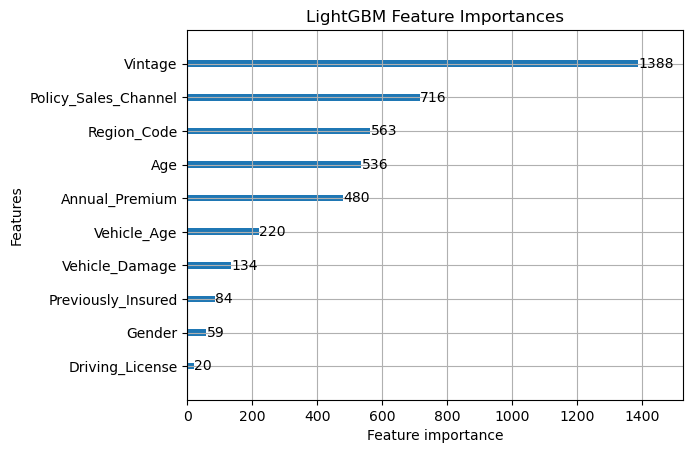

In [1]:
# LightGBM Superficial Hyperparameter Tuning Notebook

# Import Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
import lightgbm as lgb
import logging
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Setting up the logger
logging.basicConfig(level=logging.INFO, filename='lgb_superficial_tuning.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Create directories for storing graphs
os.makedirs('graphs_lgb_superficial', exist_ok=True)

# Load Data
train_path = "train_lgb_processed.csv"
test_path = "test_lgb_processed.csv"

logger.info("Loading datasets...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
logger.info("Datasets loaded successfully.")
logger.info(f"Train dataset shape: {train_df.shape}")
logger.info(f"Test dataset shape: {test_df.shape}")

# Use a 40% sample of the training data
logger.info("Sampling 40% of the training data...")
train_sample = train_df.sample(frac=0.4, random_state=42)
logger.info(f"Train sample shape: {train_sample.shape}")

# Split data into features and target
X = train_sample.drop('Response', axis=1)
y = train_sample['Response']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Set up the LightGBM dataset
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

# Define the initial parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1
}

# Define the parameter distribution for random search
param_dist = {
    'num_leaves': sp_randint(20, 50),
    'max_depth': sp_randint(3, 10),
    'min_data_in_leaf': sp_randint(10, 50),
    'feature_fraction': sp_uniform(0.6, 0.4),
    'bagging_fraction': sp_uniform(0.6, 0.4),
    'bagging_freq': sp_randint(0, 10),
    'lambda_l1': sp_uniform(0.0, 1.0),
    'lambda_l2': sp_uniform(0.0, 1.0)
}

# Set up the stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the scorer for ROC AUC
scorer = make_scorer(roc_auc_score, greater_is_better=True, response_method="predict_proba")

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lgb.LGBMClassifier(**params), param_distributions=param_dist, scoring=scorer, cv=cv, n_iter=10, verbose=1, n_jobs=-1)

# Perform the random search
logger.info("Starting superficial random search for hyperparameter tuning...")
random_search.fit(X_train, y_train)

# Get the best parameters from the random search
best_params = random_search.best_params_
best_score = random_search.best_score_
logger.info(f"Best parameters from superficial random search: {best_params}")
logger.info(f"Best ROC AUC score from superficial random search: {best_score}")

print(f"Best parameters from superficial random search: {best_params}")
print(f"Best ROC AUC score from superficial random search: {best_score}")

# Save the results
results_df = pd.DataFrame(random_search.cv_results_)
results_df.to_csv('lgb_superficial_random_search_results.csv', index=False)
logger.info('Random search results saved to lgb_superficial_random_search_results.csv')

# Train the final model with the best parameters
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the validation set
y_pred_val = final_model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred_val)
logger.info(f"Validation ROC AUC Score with best parameters: {roc_auc}")

print(f"Validation ROC AUC Score with best parameters: {roc_auc}")

# Save the final model
final_model.booster_.save_model('final_lgb_model_superficial.txt')
logger.info('Final model saved to final_lgb_model_superficial.txt')

# Visualize feature importances
lgb.plot_importance(final_model, max_num_features=20)
plt.title('LightGBM Feature Importances')
plt.savefig('graphs_lgb_superficial/lgbm_feature_importances_superficial.png')
plt.show()
logger.info('LightGBM feature importances plot saved.')
